Dados de Treino: (188533, 12)
Dados de Teste: (125690, 11)
Features finais: 92
A iniciar Grid Search (pode demorar um pouco)...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Melhores parâmetros: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.9}
Melhor RMSE (Log Scale): 0.4916
RMSE no Treino (Escala Real): 71708.72


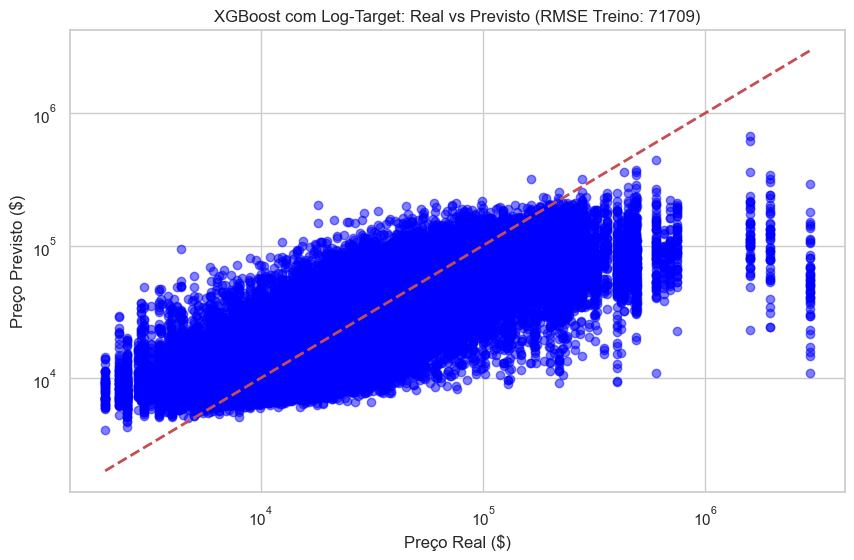

C:\Users\lucasmartins\AppData\Local\Temp\ipykernel_27100\1466039249.py:188: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feat_imp, palette='viridis')


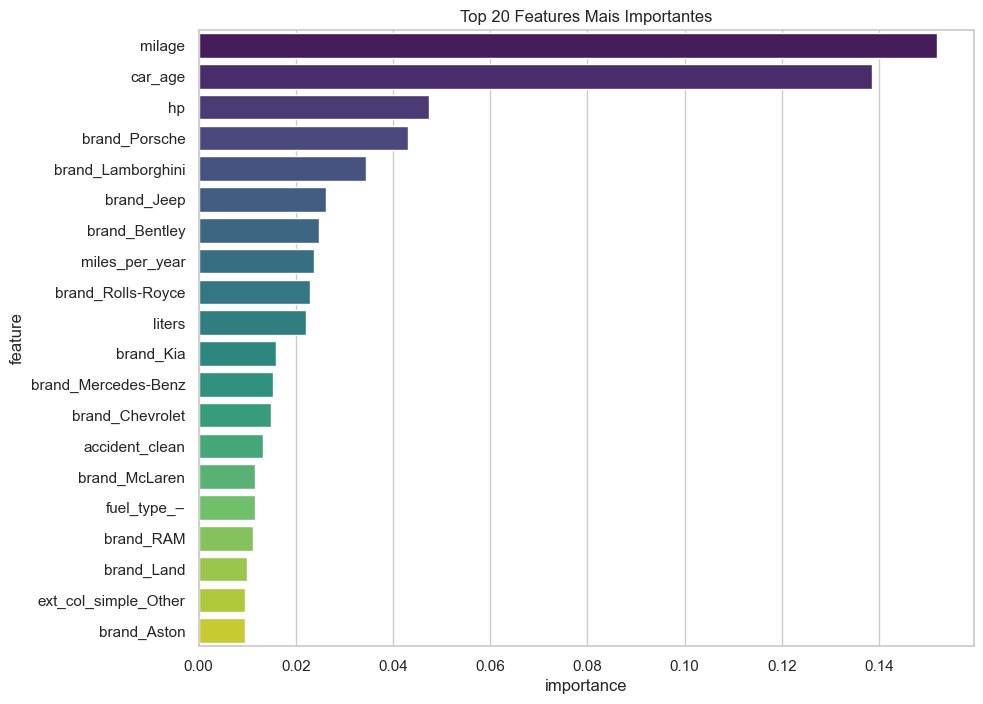

Ficheiro 'submission_improved_nopipe.csv' gerado com sucesso.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# Configuração
sns.set(style="whitegrid")
SEED = 42

# -------------------------------------------------------------------------
# 1. Carregamento e Fusão (A chave para simplificar)
# -------------------------------------------------------------------------
train = pd.read_csv('dados/train.csv', index_col='id')
test = pd.read_csv('dados/test.csv', index_col='id')

# Guardar o tamanho do treino para separar depois
n_train = len(train)

# Separar o target (Log-transform para normalizar a distribuição de preços)
y = np.log1p(train['price'])

# Juntar Treino e Teste num único DataFrame para processar tudo de uma vez
# (Removemos o price do treino para ele ficar igual ao teste)
df_all = pd.concat([train.drop('price', axis=1), test], axis=0)

print(f"Dimensão total combinada: {df_all.shape}")

# -------------------------------------------------------------------------
# 2. Feature Engineering Avançado
# -------------------------------------------------------------------------
def engineer_features(df):
    df_eng = df.copy()
    
    # --- Extração de Texto (Motor) ---
    # HP e Litros
    df_eng['hp'] = df_eng['engine'].str.extract(r'(\d+\.?\d*)HP').astype(float)
    df_eng['liters'] = df_eng['engine'].str.extract(r'(\d+\.?\d*)L').astype(float)
    
    # NOVO: Cilindros (Ex: "V6", "6 Cylinder")
    df_eng['cylinders'] = df_eng['engine'].str.extract(r'(\d+) Cylinder').astype(float)
    
    # NOVO: Flags de Performance/Tecnologia
    df_eng['is_turbo'] = df_eng['engine'].str.contains('Turbo', case=False).astype(int)
    df_eng['is_hybrid'] = df_eng['fuel_type'].str.contains('Hybrid|Electric', case=False, na=False).astype(int)
    
    # --- Idade e Uso ---
    df_eng['car_age'] = 2024 - df_eng['model_year']
    df_eng['miles_per_year'] = df_eng['milage'] / (df_eng['car_age'] + 1)
    
    # --- Simplificação de Categorias ---
    # Transmissão: Automática vs Manual vs Outra
    df_eng['is_automatic'] = df_eng['transmission'].str.contains('Automatic|A/T|CVT|Dual Shift', case=False, na=False).astype(int)
    
    # Acidentes e Título
    df_eng['has_accident'] = df_eng['accident'].apply(lambda x: 0 if 'None' in str(x) else 1)
    df_eng['clean_title'] = df_eng['clean_title'].fillna('No').apply(lambda x: 1 if x == 'Yes' else 0)
    
    # Marcas: Manter top 25, resto vira 'Other' (Reduz ruído)
    top_brands = df_eng['brand'].value_counts().nlargest(25).index
    df_eng['brand_clean'] = df_eng['brand'].where(df_eng['brand'].isin(top_brands), 'Other')

    return df_eng

# Aplicar a engenharia
df_processed = engineer_features(df_all)

# -------------------------------------------------------------------------
# 3. Preparação Simplificada (One-Hot + Imputação Global)
# -------------------------------------------------------------------------

# Selecionar colunas finais
num_cols = ['milage', 'car_age', 'hp', 'liters', 'cylinders', 'miles_per_year']
cat_cols = ['brand_clean', 'fuel_type'] # Usamos as versões limpas
bool_cols = ['is_turbo', 'is_hybrid', 'is_automatic', 'has_accident', 'clean_title']

# Imputação Rápida (Mediana para numéricos)
for col in num_cols:
    df_processed[col] = df_processed[col].fillna(df_processed[col].median())

# One-Hot Encoding (Pandas get_dummies trata categorias e ignora numéricos/booleanos)
# dummy_na=True cria coluna para nulos em categorias, drop_first=True evita redundância
cols_to_use = num_cols + cat_cols + bool_cols
df_ready = pd.get_dummies(df_processed[cols_to_use], drop_first=True)

# Separar de volta em Treino e Teste
X = df_ready.iloc[:n_train]
X_test = df_ready.iloc[n_train:]

print(f"Features prontas para treino: {X.shape[1]}")

# -------------------------------------------------------------------------
# 4. Grid Search e Treino (XGBoost)
# -------------------------------------------------------------------------

xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=SEED,
    n_jobs=-1
)

param_grid = {
    'n_estimators': [300, 500],
    'learning_rate': [0.01, 0.05],
    'max_depth': [4, 6],         # Profundidade controlada para evitar overfitting
    'subsample': [0.8],
    'colsample_bytree': [0.8]    # Usa 80% das features por árvore (bom para generalizar)
}

print("A iniciar Grid Search...")
grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1
)

grid.fit(X, y)

print(f"\nMelhores parâmetros: {grid.best_params_}")
print(f"Melhor RMSE (Log Scale): {-grid.best_score_:.4f}")

# -------------------------------------------------------------------------
# 5. Avaliação e Submissão
# -------------------------------------------------------------------------
best_model = grid.best_estimator_

# Calcular RMSE real no treino para ter noção do erro em Dólares
y_pred_log = best_model.predict(X)
rmse_real = np.sqrt(mean_squared_error(np.expm1(y), np.expm1(y_pred_log)))
print(f"RMSE (Escala Real - Dólares): {rmse_real:.2f}")

# Gráfico de Importância das Features
feat_imp = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False).head(15)
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')
plt.title('Top 15 Features Mais Importantes')
plt.show()

# Gerar Submissão
test_pred_real = np.expm1(best_model.predict(X_test)) # Reverter log
submission = pd.DataFrame({'id': test.index, 'price': test_pred_real})
submission.to_csv('submission_final_improved.csv', index=False)
print("Ficheiro 'submission_final_improved.csv' criado.")